# Machine Translation + Transformer

## 1.Import Libraries & Environment Setup

- **Environment Setup and Reproducibility Summary**:
    - **Library Imports**:
        - Import essential PyTorch libraries: `torch`, `torch.nn`, `torch.nn.functional`.
        - Include data handling utilities: `torchdata`, `torchtext`, `datasets`.
    - **Device Configuration**:
        - Detect and utilize CUDA-enabled GPU if available; fall back to CPU otherwise.
        - Optimizes computational efficiency and accelerates model training.
    - **Reproducibility**:
        - Set a global random seed and configure PyTorch for deterministic algorithms.
        - Ensures consistent results across runs for reproducible experiments.
    - **Practical Implications**:
        - GPU acceleration significantly reduces training times, facilitating more experiments.
        - Reproducibility is crucial for validating results and comparing different models and techniques.


In [2]:
import torch, torchdata, torchtext  # Importing PyTorch and auxiliary libraries for data handling.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import datasets
from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tabulate import tabulate



import random, math, time
from numpy.random import default_rng
import json

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

# Setting the device to CUDA if available, otherwise defaults to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # Outputs the device being used, helps in verifying CUDA availability.

# Setting a seed for reproducibility.
SEED = 1234
torch.manual_seed(SEED)  # Seeds the random number generators in PyTorch for all devices (CPU and CUDA).
torch.backends.cudnn.deterministic = True  # Makes certain CUDA operations deterministic.


cpu


- **Library Version Information Summary**:
    - Ensuring reproducibility and compatibility is essential for sharing or revisiting notebooks.
    - List the versions of main libraries used:
        - `torch`: Provides core functionalities for deep learning models.
        - `datasets`: Offers a wide variety of datasets for training and evaluation.
        - `torchtext`: Facilitates text preprocessing and data loading for natural language processing tasks.
    - Documenting library versions helps set up a similar environment in the future, maintaining the consistency of results and functionality.


In [51]:
# Printing the version numbers of the libraries.
# This is useful for documentation, reproducibility, and troubleshooting.
print(f"PyTorch Version: {torch.__version__}")
print(f"Datasets Version: {datasets.__version__}")

PyTorch Version: 2.1.2
Datasets Version: 2.16.1


In [4]:
import spacy
print(spacy.__version__)

3.7.2


## 2.  Dataset Loading for Machine Translation



- **Dataset Specification for Machine Translation Task**:
    - **Language Selection**:
        - **Source Language (`SRC_LANGUAGE`)**: English (`en`) - the language we translate from.
        - **Target Language (`TRG_LANGUAGE`)**: Bengali (`bn`) - the language we translate into.
    - **Dataset Selection**:
        - **Dataset Used**: OPUS-100 Corpus, with a focus on the "bn-en" language pair.
        - Chosen for its high-quality, parallel sentences, essential for effective machine translation model training.
    - **Purpose**:
        - Loading the OPUS-100 dataset is crucial for data preparation, enabling subsequent steps like preprocessing, model training, and evaluation.


In [5]:
# Define the source and target languages for translation.
SRC_LANGUAGE = 'en'  # Source language code (English).
TRG_LANGUAGE = 'bn'  # Target language code (Bengali).

# Load the dataset from the OPUS-100 corpus for the specified language pair ("bn-en").
# The dataset contains parallel sentences in English and Bengali, suitable for training translation models.
dataset = datasets.load_dataset("opus100", "bn-en")


- **Dataset Sampling and Preprocessing Overview**:
    - **Random Sampling**:
        - Initialize a random number generator with a fixed seed for reproducibility, ensuring the same sample is selected across runs.
        - Randomly select 3000 examples from the `train` split for a balanced approach to computational efficiency and dataset diversity.
    - **Preprocessing**:
        - Create separate columns for source (`SRC_LANGUAGE`) and target (`TRG_LANGUAGE`) languages, facilitating translation tasks.
        - Remove the original `translation` column post-extraction to optimize dataset structure and memory usage.
    - **Practical Steps**:
        - Utilize a fixed seed with the random number generator to ensure consistent sample selection.
        - Filter the dataset to include only the selected indices, streamlining the dataset for model training.


In [6]:
# Initialize a random number generator with a specified seed for reproducibility.
ran_rng = default_rng(seed=SEED)

# Randomly select 3000 indices from the training dataset without replacement.
select_idx = ran_rng.choice(len(dataset['train']), size= 3000, replace=False)

# Filter the training dataset to only include the selected indices.
dataset['train'] = dataset['train'].filter(lambda example, idx: idx in select_idx, with_indices=True)

In [7]:
dataset['train']

Dataset({
    features: ['translation'],
    num_rows: 3000
})

In [8]:
# Function to extract language-specific data from the 'translation' dictionary.
lang_cols = lambda example, lang: {lang: example['translation'][lang]}

# Apply the function to create a column for English sentences.
dataset = dataset.map(lang_cols, fn_kwargs={'lang': "en"})

Map: 100%|██████████| 3000/3000 [00:01<00:00, 2541.12 examples/s]


In [9]:
dataset

DatasetDict({
    test: Dataset({
        features: ['translation', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation', 'en'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['translation', 'en'],
        num_rows: 2000
    })
})

In [10]:

# Apply the function again to create a column for Bengali sentences and remove the 'translation' column.
dataset = dataset.map(lang_cols, remove_columns=['translation'], fn_kwargs={'lang': "bn"})


Map: 100%|██████████| 3000/3000 [00:00<00:00, 16109.39 examples/s]


In [11]:
dataset['train']

Dataset({
    features: ['en', 'bn'],
    num_rows: 3000
})

- **Manual Train-Test Split Overview**:
    - **Custom Function for Train-Test Split**:
        - Defines a function to partition the dataset into training, validation, and testing sets, ensuring data is appropriately distributed for all stages of model development.
        - Incorporates a `random_state` parameter to seed the random number generator for reproducible splits.
    - **Process Steps**:
        - The dataset is shuffled and split based on a specified test size ratio to ensure randomized selection of data points, aiming to mitigate biases.
        - The split function is used twice to first obtain training and temporary subsets, then to divide the temporary subset into validation and testing sets.
    - **Sequential Splits**:
        - This approach secures distinct data sets for training, validation, and testing, crucial for thorough model evaluation and the assessment of generalizability.
    - **Implementation Considerations**:
        - The splitting methodology is designed for flexibility, accommodating different dataset sizes and structures.
        - It guarantees that validation and test sets are separate, which is vital for accurate performance evaluation.


In [12]:
def manual_train_test_split(dataset, test_size=0.3, random_state=42):
    random.seed(random_state)  # Seed the random number generator for reproducibility.
    indices = list(range(len(dataset)))  # Create a list of indices for the dataset.
    random.shuffle(indices)  # Shuffle the indices to randomize data selection.

    split_idx = int(len(dataset) * (1 - test_size))  # Calculate the index for splitting the dataset.

    # Divide the indices into training and testing subsets.
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # Use the selected indices to gather the corresponding data points.
    train_data = [dataset[i] for i in train_indices]
    test_data = [dataset[i] for i in test_indices]

    return train_data, test_data  # Return the split datasets.

# Split the dataset into training and temporary subsets.
train_data, temp_data = manual_train_test_split(dataset['train'], test_size=0.3, random_state=42)

# Further split the temporary data into validation and test sets.
val_data, test_data = manual_train_test_split(temp_data, test_size=0.5, random_state=42)


In [13]:
len(train_data), len(val_data), len(test_data)

(2100, 450, 450)

In [14]:
dataset['train'][1]

{'en': 'Unable to open %1', 'bn': '% 1 খোলা যায়নি'}

## 3. Preprocessing




- **Tokenizing with spaCy Models**:
    - **Language Models**:
        - Utilize spaCy for advanced text processing tasks including tokenization, part-of-speech tagging, and named entity recognition.
        - **Models for Download**:
            - **`xx_ent_wiki_sm`**: Multi-language model for entity recognition across various languages. Ideal for multi-language projects or preliminary analysis on mixed-language datasets. We used here for Bangla as it works quite better for Bangla.
            - **`en_core_web_sm`**: Small English model optimized for web content. Strikes a balance between processing speed and accuracy for basic NLP tasks.
    - **Model Download Commands**:
        - Instructions provided to download the necessary spaCy models using command line. These models are essential for preprocessing text data effectively.


In [15]:
!python3 -m spacy download xx_ent_wiki_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 20.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')


In [16]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


- **Tokenization Process Overview**:
    - **Fundamental NLP Step**:
        - Tokenization breaks down text into manageable units (words/subwords) for analysis by machine learning models.
    - **Implementation with spaCy**:
        - Use spaCy to set up tokenizers for both source and target languages, enhancing preprocessing with its advanced tokenization capabilities.
    - **Setup Details**:
        - Initialize `token_transform` and `vocab_transform` dictionaries for tokenization and vocabulary functions, streamlining text data preprocessing.
        - **Language-Specific Tokenizers**:
            - Target language tokenizer uses `'xx_ent_wiki_sm'` 
            - Source language (English) tokenizer relies on `'en_core_web_sm'`, optimized for web text with efficient tokenization and tagging.


In [17]:
train_data[1][SRC_LANGUAGE] , train_data[1][TRG_LANGUAGE]

('You want these fools to pick on you every day?',
 'ওরা তোকে রোজ জ্বালালে ভালো লাগবে?')

In [18]:
# Initialize dictionaries to hold tokenization and vocabulary functions.
token_transform = {}
vocab_transform = {}

# Configure tokenizers for the target and source languages using spaCy models.
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='xx_ent_wiki_sm')  # Target language tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')  # Source language tokenizer

# Display an example of tokenization for demonstration purposes.
print("Sentence: ", train_data[200][SRC_LANGUAGE])  # Print a sample sentence from the train dataset.
# Tokenize the sample sentence and print the tokens to illustrate the tokenizer's output.
print("Tokenization: ", token_transform[SRC_LANGUAGE](train_data[200][SRC_LANGUAGE]))


Sentence:  First player:
Tokenization:  ['First', 'player', ':']


- **Dataset Tokenization Overview**:
    - **Custom Tokenization Function (`tokenize_data`)**:
        - Designed for adaptability across different languages, with conditional preprocessing steps to cater to language-specific nuances (e.g., lowercasing for English).
    - **Highlights of the Process**:
        - **Adaptive Processing**: Customizes tokenization based on the linguistic characteristics of each language, ensuring data uniformity and optimizing it for NLP tasks.
        - **Graceful Error Handling**: Implements try-except blocks to maintain robustness, allowing the tokenization process to proceed smoothly even in the face of errors.
        - **Streamlining Data**: Post-tokenization, the original text columns are removed from the dataset, making it more concise and primed for efficient model training.
    - **Benefit**:
        - By considering linguistic characteristics during preprocessing, this method optimizes the dataset for enhanced performance in subsequent machine learning models.



In [19]:
def tokenize_data(example, lang):
    # Conditionally process text based on the language.
    if lang == 'en':  # For English, apply lowercasing before tokenization.
        try:
            # Attempt to tokenize the lowercased text and handle exceptions gracefully.
            return {lang: token_transform[lang](example[lang].lower())}
        except:
            # Fallback behavior in case of an error during tokenization.
            return {lang: token_transform[lang](example[lang].lower())}
    else:
        # For other languages (e.g., Bengali), skip lowercasing.
        try:
            # Tokenize the text directly without modifying case.
            return {lang: token_transform[lang](example[lang])}
        except:
            # Fallback behavior for other languages in case of an error.
            return {lang: token_transform[lang](example[lang])}

# Tokenize the dataset for the source language and remove original text columns.
tokenized_dataset = dataset['train'].map(tokenize_data, fn_kwargs={'lang': SRC_LANGUAGE})

Map: 100%|██████████| 3000/3000 [00:00<00:00, 5189.99 examples/s]


In [20]:
dataset['train']

Dataset({
    features: ['en', 'bn'],
    num_rows: 3000
})

In [21]:
tokenized_dataset

Dataset({
    features: ['en', 'bn'],
    num_rows: 3000
})

In [22]:
# Repeat the tokenization for the target language, removing the original text columns.
tokenized_dataset = tokenized_dataset.map(tokenize_data, fn_kwargs={'lang': TRG_LANGUAGE})

Map: 100%|██████████| 3000/3000 [00:00<00:00, 4393.25 examples/s]


In [23]:
tokenized_dataset[SRC_LANGUAGE][1]

['unable', 'to', 'open', '%', '1']

In [24]:
tokenized_dataset[TRG_LANGUAGE][1]

['%', '1', 'খোলা', 'যায়নি']

##### Special Symbols for Tokenization

In NLP tasks, especially in machine translation, it's crucial to define special symbols that serve specific purposes. These include unknown words (`<unk>`), padding (`<pad>`), start-of-sentence (`<sos>`), and end-of-sentence (`<eos>`) markers. Properly indexing these symbols is essential for model training and inference.

**Key Points** :
- **Uniform Indexing**: Assigns unique indices to each special symbol for easy identification.
- **Ordering**: Ensures symbols are listed in the same order as their indices for consistent vocabulary incorporation.


In [25]:
# Define indices for special symbols to ensure consistency across the dataset and model
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3  # Indices for unknown, padding, start, and end symbols

# List of special symbols in order corresponding to their indices
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']  # Essential for tokenization and sequence handling

# These symbols and indices are critical in tasks like sequence modeling and machine translation,
# where handling unknown tokens, padding for batch processing, and identifying sentence boundaries are necessary.


In [26]:
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang] = torchtext.vocab.build_vocab_from_iterator(tokenized_dataset[lang],
                                                                      min_freq=3,   #if not, everything will be treated as UNK
                                                                      specials=special_symbols,
                                                                      special_first=True) #indicates whether to insert symbols at the beginning or at the end)
    # Set UNK_IDX as the default index. This index is returned when the token is not found.
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
    vocab_transform[lang].set_default_index(UNK_IDX)

#### Checking numericalization of Specail Symbols

- **Inspecting Vocabulary for Each Language**:
    - Iterates over both source and target languages, displaying the vocabulary size for each.
    - Checks for the presence of predefined special symbols within each vocabulary.
    - **Key Outputs**:
        - **Vocabulary Size**: Displays the total number of unique tokens in the vocabulary for each language, indicative of the linguistic diversity covered.
        - **Special Tokens**: For each specified special symbol (e.g., BOS, EOS tokens), the script checks its presence in the vocabulary and displays its index if found.
    - **Purpose**:
        - This process helps in understanding the composition and coverage of the vocabularies, ensuring essential tokens like special symbols are properly included for effective model training and sequence processing.


In [27]:
# Assuming vocab_transform is a dictionary with vocabularies for each language
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    print(f"--- Vocabulary for {lang.upper()} ---")
    print(f"Vocabulary size: {len(vocab_transform[lang])}")

    for token in special_symbols:
        if token in vocab_transform[lang].get_stoi():
            print(f"Special token '{token}' index: {vocab_transform[lang][token]}")
        else:
            print(f"Special token '{token}' not found in vocabulary")


--- Vocabulary for EN ---
Vocabulary size: 1625
Special token '<unk>' index: 0
Special token '<pad>' index: 1
Special token '<sos>' index: 2
Special token '<eos>' index: 3
--- Vocabulary for BN ---
Vocabulary size: 2023
Special token '<unk>' index: 0
Special token '<pad>' index: 1
Special token '<sos>' index: 2
Special token '<eos>' index: 3


#### Check  tokenization & numericalization

- **Displaying Samples: Original, Tokenized, and Numericalized Text**:
    - **Setup**:
        - Specifies the number of samples (`num_samples_to_display`) to display for both source (`en`) and target (`bn`) languages.
    - **Process for Each Language**:
        - Iterates through a specified number of samples, displaying the original text, then processing it based on language-specific rules (e.g., converting English text to lowercase).
    - **Tokenization and Numericalization**:
        - Text is tokenized using `token_transform` functions tailored to each language.
        - Tokenized text is then numericalized using `vocab_transform`, converting tokens into numerical IDs.
    - **Display Details**:
        - Shows the original text, tokenized list, numericalized IDs, and optionally converts IDs back to tokens for inspection, demonstrating the complete preprocessing pipeline.
    - **Purpose**:
        - This process illustrates how textual data undergoes transformation from its original form through tokenization to numericalization, readying it for machine learning models.


In [28]:
# Assuming 'token_transform' is a function or a dictionary of functions for tokenizing
# And 'vocab_transform' is a dictionary of vocabularies for numericalization

num_samples_to_display = 5  # Number of samples want to display

for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:  # SRC_LANGUAGE = 'en', TRG_LANGUAGE = 'bn'
    print(f"--- {lang.upper()} Samples (Original, Tokenized, and Numericalized) ---")
    for i in range(num_samples_to_display):
        # Display original text
        original_text = dataset['train'][i][lang]

        # Convert English text to lowercase before processing
        if lang == 'en':
            processed_text = original_text.lower()
        else:
            processed_text = original_text

        print(f"Original Sample {i+1}: {original_text}")

        # Tokenization
        tokenized_text_list = token_transform[lang](processed_text)  # Tokenize the processed text
        print(f"Tokenized Sample {i+1}: {tokenized_text_list}")

        # Numericalization
        numericalized_text = [vocab_transform[lang][token] for token in tokenized_text_list]
        print(f"After Numericalization {i+1}: {numericalized_text}")

        # Reverse lookup from numerical IDs to tokens (optional for inspection)
        # Ensure our vocabulary object supports a method for ID to token conversion
        tokens_from_ids = [vocab_transform[lang].lookup_token(id) for id in numericalized_text] if hasattr(vocab_transform[lang], 'lookup_token') else [vocab_transform[lang].get_itos()[id] for id in numericalized_text]
        print(f"Tokens from IDs {i+1}: {tokens_from_ids}\n")


--- EN Samples (Original, Tokenized, and Numericalized) ---
Original Sample 1: Fear the Day when you shall be made to return to God ; then every soul shall be paid in full what it has earned ; and they shall not be wronged .
Tokenized Sample 1: ['fear', 'the', 'day', 'when', 'you', 'shall', 'be', 'made', 'to', 'return', 'to', 'god', ';', 'then', 'every', 'soul', 'shall', 'be', 'paid', 'in', 'full', 'what', 'it', 'has', 'earned', ';', 'and', 'they', 'shall', 'not', 'be', 'wronged', '.']
After Numericalization 1: [338, 6, 85, 64, 10, 86, 37, 136, 9, 422, 9, 78, 56, 70, 201, 380, 86, 37, 1076, 12, 360, 43, 18, 59, 0, 56, 7, 20, 86, 21, 37, 0, 4]
Tokens from IDs 1: ['fear', 'the', 'day', 'when', 'you', 'shall', 'be', 'made', 'to', 'return', 'to', 'god', ';', 'then', 'every', 'soul', 'shall', 'be', 'paid', 'in', 'full', 'what', 'it', 'has', '<unk>', ';', 'and', 'they', 'shall', 'not', 'be', '<unk>', '.']

Original Sample 2: Unable to open %1
Tokenized Sample 2: ['unable', 'to', 'open', '%',

## 4. Preparing the dataloader






- **Preparing the Dataloader for Text Data**:
    - **Transformation Steps**:
        - The process involves tokenization, numericalization, addition of special tokens (SOS/EOS for sentence boundaries), and conversion into tensor format.
    - **Sequential Operations**:
        - Utilizes a helper function to streamline the transformation steps, ensuring raw text is appropriately structured for neural network processing.
    - **Special Token Addition**:
        - Incorporates Start Of Sentence (SOS) and End Of Sentence (EOS) tokens to each sequence, marking clear sentence boundaries.
    - **Collation Function**:
        - Implements a custom function to collate data into batches, padding sequences to a uniform length for efficient batch processing.
    - **Importance**:
        - These steps are essential for converting variable-length text data into a standardized form, allowing neural networks to effectively learn from sequences.

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except TypeError:
                txt_input = transform.word_tokenize(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# Assuming the existence of text_transform functions that tokenize and numericalize the input text
# Let's also assume PAD_IDX is defined somewhere in our code, representing the padding index

def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        # Process source text (English)
        # Ensure the text is lowercased if the source language is English
        src_text = sample[SRC_LANGUAGE].rstrip("\n").lower() if SRC_LANGUAGE == 'en' else sample[SRC_LANGUAGE].rstrip("\n")

        processed_src_text = text_transform[SRC_LANGUAGE](src_text)

        src_batch.append(processed_src_text)

        # Process target text (e.g., Bengali, which does not require lowercasing)
        trg_text = sample[TRG_LANGUAGE].rstrip("\n")  # No lowercasing for TRG_LANGUAGE
        processed_trg_text = text_transform[TRG_LANGUAGE](trg_text)
        trg_batch.append(processed_trg_text)

        src_len_batch.append(processed_src_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch



# Batch size definition
batch_size = 64

# DataLoader instantiation for train, validation, and test sets
# Assuming train_set, val_set, and test_set are already defined datasets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

- **Inspecting DataLoader Batches**:
    - **Utility Function (`inspect_loader_with_words`)**:
        - Designed to provide detailed insights into the structure and content of batches produced by the `DataLoader`.
    - **Features**:
        - **Batch Structure Overview**: Shows the shape of source and target batches and sequence lengths in the source batch, offering insights into the data structure presented to the model.
        - **Content Inspection**: Facilitates qualitative evaluation by converting numerical IDs back to textual tokens, allowing for a direct view into the processed data.
    - **Purpose**:
        - Acts as a crucial tool for debugging and validating the data preprocessing pipeline, ensuring data is formatted correctly for model training and evaluation.


In [ ]:
def inspect_loader_with_words(data_loader, loader_name, vocab_src, vocab_tgt):
    print(f"Inspecting {loader_name}:")
    for src_batch, src_lens, trg_batch in data_loader:
        print(f"Source batch shape: {src_batch.shape}")
        print(f"Source lengths: {src_lens}")
        print(f"Target batch shape: {trg_batch.shape}")

        # Convert the first few numerical IDs back to tokens for the source batch
        src_sample_tokens = [vocab_src.lookup_token(token_id.item()) for token_id in src_batch[1][:min(10, src_lens[0])]]
        print(f"First sample in source batch (tokens): {src_sample_tokens}")

        # Convert the first few numerical IDs back to tokens for the target batch
        trg_sample_tokens = [vocab_tgt.lookup_token(token_id.item()) for token_id in trg_batch[1][:10]]  # Assuming the first 10 tokens
        print(f"First sample in target batch (tokens): {trg_sample_tokens}\n")

        # Break after the first batch to only inspect the first batch
        break

# Assuming vocab_src and vocab_tgt are your source and target vocabularies
# with a method `lookup_token(id)` that retrieves the token given its numerical ID
vocab_src = vocab_transform[SRC_LANGUAGE]
vocab_tgt = vocab_transform[TRG_LANGUAGE]
inspect_loader_with_words(train_loader, "Train Loader", vocab_src, vocab_tgt)
inspect_loader_with_words(valid_loader, "Validation Loader", vocab_src, vocab_tgt)
inspect_loader_with_words(test_loader, "Test Loader", vocab_src, vocab_tgt)


Inspecting Train Loader:
Source batch shape: torch.Size([64, 84])
Source lengths: tensor([30, 41,  5,  9,  9, 30, 10,  7,  9,  6, 11, 18, 13,  7, 23, 10, 22,  7,
         5,  7, 46,  5,  3,  3,  8, 10,  6, 14, 11, 31,  5, 27, 37, 55,  6, 17,
        11, 68,  8,  6, 53,  3,  8,  4,  4, 13, 23, 41,  3,  4, 18, 26, 23, 12,
        44,  4,  4, 10, 53, 38, 84,  5, 11,  8])
Target batch shape: torch.Size([64, 103])
First sample in source batch (tokens): ['<sos>', 'in', 'this', '<unk>', 'he', 'explains', 'why', 'transparency', 'and', '<unk>']
First sample in target batch (tokens): ['<sos>', '<unk>', '<unk>', 'তিনি', 'ব্যাখ্যা', 'করছেন', 'যে', 'স্বচ্ছতা', 'ও', '<unk>']

Inspecting Validation Loader:
Source batch shape: torch.Size([64, 69])
Source lengths: tensor([ 5, 37,  6, 11, 10,  9, 11, 16,  8,  4, 45,  6, 14,  9, 34, 38,  5,  6,
        11, 33, 14,  4, 10, 10,  5,  8, 64, 48,  7, 13,  5, 14, 17, 11,  4,  7,
        35, 13,  5, 12, 69,  7,  7, 10,  7, 11, 59, 27,  6,  8,  4, 42,  6, 37,
  

In [ ]:
for en, _, bn in train_loader:
    # Iterate over the training DataLoader to retrieve the first batch.
    # The loop breaks after the first iteration, providing us with the initial batch of data.
    break

# Checking the shapes of the tensors for English and Bengali sequences in the first batch.
# This helps to verify the preprocessing and batch collation steps, ensuring they are as expected.
en.shape, bn.shape  # Returns the shapes of the input (English) and output (Bengali) tensors, respectively.


(torch.Size([64, 47]), torch.Size([64, 50]))

## 5. Design the model

### Encoder Layer

- **EncoderLayer Class Overview**:
    - Represents a single layer within the Transformer model encoder, essential for transforming input sequences into higher-level representations.
    - **Key Components**:
        - **Self-Attention Mechanism**: Enables the encoder to account for the entire input sequence when encoding a specific word, capturing context and dependencies.
        - **Positionwise Feedforward Network**: Applies a fully connected network to each position, enhancing the transformation from the self-attention mechanism.
        - **Normalization and Dropout**: Incorporates layer normalization before, and dropout after each sub-layer (self-attention and feedforward) to enhance generalization and prevent overfitting.
    - **Process Flow**:
        1. **Self-Attention**: Processes the input with an attention mechanism to generate a weighted representation.
        2. **Addition and Normalization**: Combines the self-attention output with the original input (residual connection) and normalizes this sum.
        3. **Feedforward Network**: Further transforms the data through a positionwise feedforward network.
        4. **Final Addition and Normalization**: Applies another residual connection and normalization step after the feedforward network.
    - **Purpose**:
        - Each layer is crucial for understanding complex relationships in the input, leveraging self-attention and feedforward networks to prepare data for subsequent layers or decoder usage in sequence generation tasks.


In [29]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AttentionLayer(hid_dim, n_heads, dropout, device,attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

- **Encoder Class Overview**:
    - Forms the core of the Transformer model's encoder, converting input sequences into rich continuous representations that encapsulate semantic and contextual relationships.
    - **Key Components**:
        - **Token Embedding**: Converts tokens to vectors in a high-dimensional space, facilitating semantic similarity.
        - **Positional Embedding**: Adds information about the token positions within the sequence, enabling the model to recognize word order.
        - **Encoder Layers**: Applies self-attention and position-wise feedforward networks across multiple layers to refine the input representation with context.
        - **Dropout**: Enhances generalization by randomly omitting a portion of the inputs in the embedding stage.
    - **Process Flow**:
        1. **Embedding and Scaling**: Input tokens are first embedded and scaled, with positional embeddings added to this mix to include sequence order information.
        2. **Layer-wise Transformation**: These embeddings are then sequentially processed by encoder layers, each layer enriching the representation through self-attention and feedforward networks.
        3. **Output**: Results in a comprehensive output that captures the essence of each token and their interrelations within the sequence.
    - **Purpose**:
        - The Encoder is pivotal in transforming input sequences into contextually enriched representations, laying the groundwork for subsequent decoding or direct application in tasks like classification or entity recognition.


In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


- **AttentionLayer Class Overview**:
    - Central to Transformer architectures, this class facilitates selective emphasis on different parts of the input sequence through various attention mechanisms.
    - **Key Features**:
        - **Configurability**: Supports General, Multiplicative, and Additive attention types, enabling flexibility to tackle diverse data modeling challenges.
        - **Equations for Attention Mechanisms**:

            1. **General Attention**: 
            
            $$e_i = \mathbf{s}^\text{T}\mathbf{h}_i \in \mathbb{R} \quad \text{where} \quad d_1 = d_2$$


            2. **Multiplicative Attention**:
            $$e_i = \mathbf{s}^\text{T}\mathbf{W}\mathbf{h}_i \in \mathbb{R} \quad \text{where} \quad \mathbf{W} \in \mathbb{R}^{d_2 \times d_1}$$


            3. **Additive Attention**: 
        $$e_i = \mathbf{v}^\text{T} \tanh(\mathbf{W}_1\mathbf{h}_i + \mathbf{W}_2\mathbf{s}) \in \mathbb{R}$$


  - These equations delineate how each attention type calculates the energy score \(e_i\), which is pivotal for determining the focus areas of the model's input sequence.
        - **Components**:
            - **Self-Attention Mechanism**: Utilizes self-attention for dynamic weighting of input elements, crucial for capturing dependencies.
            - **Normalization and Dropout**: Implements layer normalization and dropout to improve model stability and reduce overfitting.
    - **Implementation Details**:
        - **Initialization**: Ensures hidden dimension compatibility with attention heads and sets up linear transformations for `Q`, `K`, `V`, and output layers.
        - **Forward Pass**:
            - Transforms and prepares `Q`, `K`, `V` for multi-head attention.
            - Calculates energy scores uniquely for each attention type, facilitating different computational approaches to model input dependencies.
    - **Output**:
        - Produces attention-modified output and weights, highlighting the model's focus areas and significantly boosting its capability to analyze and generate complex sequences.


In [31]:
class AttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, attn_type = 'Gen_Attn'):
        super().__init__()
        assert hid_dim % n_heads == 0  # Ensure the hidden dim is divisible by the number of heads

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_type = attn_type

        # Define linear layers for Q, K, and V
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Output linear layer
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        # Initialize the weight matrix W for Multiplicative Attention
        self.W = nn.Linear(self.head_dim, self.head_dim)

                # Define linear layers for additive attention
        self.W1 = nn.Linear(self.head_dim, self.head_dim)  # Transform hi (K)
        self.W2 = nn.Linear(self.head_dim, self.head_dim)  # Transform s (Q)
        self.v = nn.Linear(self.head_dim, 1)  # Projection vector v

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        # Linear transformations for Q, K, V
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape and permute for multi-head attention
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)


        if self.attn_type == 'General_Attn':
            # General attention: Calculate energy scores
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.attn_type == 'Multiplicative_Attn':
            # Multiplicative attention: Calculate energy scores

            # 1. Transform the key vector K using the weight matrix W (W * h_i in the equation)

            transformed_Q = self.W(Q)

            # 2. Calculate the dot product of the query Q with the transformed key (s^T * W * h_i in the equation)
            # This computes the attention scores (energies) for the query and key pairs
            energy = torch.matmul(transformed_Q,  K.permute(0, 1, 3, 2)) # K is permuted to match the dimensions for matrix multiplication with W
        elif self.attn_type == 'Additive_Attn':
            # Ensure the reshaping and operations align correctly
            transformed_Q = self.W1(Q.unsqueeze(3))  # [batch_size, n_heads, key_len, head_dim]
            transformed_K = self.W2(K.unsqueeze(2))  # [batch_size, n_heads, query_len, head_dim]
            # Since the error mentions a mismatch, double-check the shapes of K and Q before transformation
            # print("K shape:", K.shape)
            # print("Q shape:", Q.shape)
            # print("transformed_K shape:", transformed_K.shape)
            # print("transformed_Q shape:", transformed_Q.shape)

            # The broadcasting should work without unsqueeze if dimensions are aligned correctly
            # If unsqueeze is used, it should be to introduce a compatible dimension for broadcasting
            energy = torch.tanh(transformed_Q + transformed_K)
            # print("energy shape before squeeze(-1):", energy.shape)
            energy = self.v(energy).squeeze(-1)
            # print("energy shape after squeeze(-1):", energy.shape)

        # Apply mask (if provided) to ignore certain positions in the attention scores
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Compute attention weights by applying softmax to the energy scores
        attention = torch.softmax(energy, dim=-1)

        # Apply the attention weights to the value vector V
        x = torch.matmul(self.dropout(attention), V)

        # Reshape and project the output back to the original hid_dim
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention


### Position-wise Feedforward Layer

- **PositionwiseFeedforwardLayer Summary**:
    - An essential component of the Transformer model that processes inputs at each sequence position independently, facilitating the learning of complex patterns.
    - **Key Features**:
        - **Expansion and Non-linearity**: Expands the input's dimensionality and applies ReLU activation, enabling the model to capture non-linear relationships.
        - **Regularization with Dropout**: Implements dropout as a regularization technique to prevent overfitting, thereby enhancing the model's generalization capability.
        - **Dimensional Restoration**: Compresses the output back to the model's original dimension, ensuring uniformity across the Transformer's architecture.
    - **Role in the Transformer**:
        - By providing uniform yet customizable processing for each position, this layer significantly contributes to the model's ability to learn nuanced and flexible representations, adding depth and versatility to the Transformer's encoding capabilities.


In [41]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

- **DecoderLayer Overview**:
    - A vital part of the Transformer model's decoder, designed to generate the output sequence by processing the target sequence in the context of the encoded source sequence.
    - **Key Functions**:
        - **Self-Attention**: Helps the decoder understand various parts of the target sequence by focusing on different positions within it.
        - **Encoder-Decoder Attention**: Integrates context from the source sequence into the decoding process, allowing the decoder to focus on relevant parts of the source.
        - **Positionwise Feedforward Networks**: Enhances the target sequence representation by individually transforming each token, contributing to the model's depth.
        - **Normalization and Dropout**: Ensures learning stability and regularization by being applied after each sub-layer.
    - **Process Overview**:
        1. **Self-Attention with Masking**: Ensures causality by preventing the decoder from attending to future tokens in the target sequence.
        2. **Attention to Encoder Output**: Leverages the encoder's output to incorporate source-side context.
        3. **Positionwise Transformation**: Applies a feedforward network to transform each token's representation.
        4. **Layer Normalization**: Normalizes activations post each sub-layer, aiding in training stability.
    - **Impact**:
        - Through a sophisticated layering of self-attention, encoder-decoder attention, and feedforward networks, the decoder adeptly generates output tokens, informed by both the input sequence and the sequence generated thus far.


In [32]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, attn_type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = AttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.encoder_attention    = AttentionLayer(hid_dim, n_heads, dropout, device, attn_type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

- **Decoder Class Overview**:
    - Central to the Transformer model's decoding process, tasked with generating the output sequence from the encoded source sequence.
    - **Core Components**:
        - **Token and Positional Embeddings**: Transform target sequence tokens into vectors, enriched with positional data to capture sequence content and order.
        - **Decoder Layers**: Layers that process the target sequence by applying self-attention, encoder-decoder attention, and position-wise feedforward networks, iteratively refining the sequence representation.
        - **Output Linear Layer**: Maps the refined representations to the vocabulary space, enabling next-token prediction.
        - **Dropout and Scaling**: Ensures regularization and maintains embedding variance across the decoder layers.
    - **Processing Flow**:
        1. **Embedding and Position Encoding**: Embeds the target sequence, adds positional information, scales, and applies dropout.
        2. **Sequential Layer Processing**: Passes the sequence through decoder layers, each layer contributing to a richer representation by leveraging attention mechanisms.
        3. **Final Projection**: Projects the enhanced target sequence representation to the vocabulary space, generating final sequence predictions.
    - **Functionality**:
        - The `Decoder` class encapsulates the sequential transformation of the target sequence, employing a series of sophisticated layers to ensure the output sequence is generated with a comprehensive understanding of both the sequence itself and its context within the source sequence.


In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, attn_type, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, attn_type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

- **Seq2SeqTransformer Class Overview**:
    - Integrates encoder and decoder components to form a complete sequence-to-sequence Transformer model, suited for translation or sequence generation tasks.
    - **Model Components**:
        - **Encoder**: Transforms the input sequence into a continuous representation, capturing semantic nuances.
        - **Decoder**: Iteratively generates the output sequence, leveraging the encoded input and previously generated tokens.
        - **Source and Target Masks**: Applied to manage attention focus and maintain causal integrity across sequences.
    - **Key Features**:
        - **Masking**: Prevents future token peeking in the decoder and manages padding token attention in the encoder, critical for maintaining sequence order and relevance.
        - **Parameter Storage**: Holds model parameters, facilitating easy access during inference and ensuring consistent handling of padding indices.
    - **Adaptability and Efficiency**:
        - The architecture supports parallelizable training and versatile application across various sequence modeling tasks, including translation and summarization.
    - **Forward Pass**:
        - Executes a forward pass by applying masks, processing input through the encoder to capture context, and generating output with the decoder, employing self-attention and encoder-decoder attention to refine output generation.


In [34]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        # store the input parameters so we can retrive them later for model inferencing
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

- **Weight Initialization Overview**:
    - Essential for stabilizing deep neural network training, preventing early training issues like vanishing or exploding gradients.
    - **Key Concept**:
        - **Xavier Uniform Initialization**: Adopts a uniform distribution for initial weights, scaled by the layer's dimensions, to preserve activation and gradient variance across the network.
    - **Application**:
        - Applied across the Transformer model's linear components, including encoder, decoder, and positionwise feedforward networks, setting a uniform standard for initial weights and fostering effective training.


In [35]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

- **Transformer Model Configuration for Translation**:
    - Tailored for sequence-to-sequence tasks, featuring an encoder and decoder architecture designed to handle language complexities.
    - **Model Parameters**:
        - **Input/Output Dimensions**: Reflect the source and target vocabulary sizes.
        - **Hidden Dimension (`hid_dim`)**: Determines the size of internal vectors, key to the model's representational capacity.
        - **Number of Layers**: Depth of encoder and decoder, influencing the model's ability to process sequences.
        - **Number of Attention Heads**: Facilitates the model's focus on various sequence parts simultaneously.
        - **Feedforward Dimension**: Size of the hidden layer in position-wise feedforward networks, affecting data transformation.
        - **Dropout Rate**: Helps mitigate overfitting by omitting a fraction of units randomly during training.
    - **Hyperparameters**:
        - **Batch Size**: Defines how many sequences are processed together.
        - **Learning Rate**: Adjusts optimization step size for effective learning.
        - **Epochs**: Indicates the total training cycles through the dataset.
        - **Gradient Clipping**: Prevents excessively large gradients, ensuring stable training.
    - **Initialization**:
        - Implements Xavier uniform initialization across the model's weights to promote balanced and efficient training dynamics.


In [ ]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])


batch_size = 64
lr = 0.0005
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

num_epochs = 10
clip       = 1

In [ ]:
# List of attention types
attn_type_li = ['General_Attn', 'Multiplicative_Attn', 'Additive_Attn']

# Dictionary to store initialized models
models = {}

# Loop over each attention type
for attn_type in attn_type_li:
    print(f"\n****************{attn_type}****************\n")
    # Initialize encoder
    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  device,
                  attn_type
                  )

    # Initialize decoder
    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  device,
                  attn_type)

    # Create Seq2SeqTransformer model with specified attention type
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    
    # Apply weight initialization
    model.apply(initialize_weights)
    
    # Store initialized model in the dictionary with attention type as key
    models[attn_type] = model

    # Print number of parameters for the current model
    print(models[attn_type])



****************General_Attn****************

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(1625, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (W1): Linear(in_features=32, out_features=32, bias=True)
          (W2): Linear(in_features=32, out_features=32, bias=True)
          (v): Linear(in_feat

- **Model Complexity Evaluation Overview**:
    - Assessing a neural network's complexity is key to understanding its capacity, memory needs, and computational demands.
    - **Functionality of `count_parameters`**:
        - **Trainable Parameters**: Focuses on parameters set to require gradients, highlighting those actively learned during training.
        - **Detailed Breakdown**: Offers a layer-wise look at complexity by reporting the number of elements (`numel`) in each trainable parameter tensor.
        - **Total Count**: Provides a cumulative figure of trainable parameters, serving as a straightforward metric of the model's overall complexity.
    - **Importance**:
        - Helps in comparing different model designs or configurations, shedding light on their relative capacities.
        - Assists in evaluating the risk of overfitting or underfitting based on the model's size and the volume of training data.


In [ ]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

for attn_type, model in models.items():
    print(f"Model with {attn_type} attention:")
    count_parameters(model)

Model with General_Attn attention:
416000
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
517888
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
  1024
    32

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

- **Training Function for Sequence-to-Sequence Models Overview**:
    - Orchestrates the training process for a single epoch, crucial for refining the model's parameters to enhance prediction accuracy.
    - **Key Steps**:
        - **Forward Pass**: Executes model inference on each source-target pair, adjusting target sequences to align inputs and outputs correctly for learning.
        - **Loss Computation**: Employs a specified criterion to evaluate the discrepancy between model predictions and actual target sequences.
        - **Backward Pass and Optimization**: Derives gradients from the loss and updates model parameters, incorporating gradient clipping to mitigate exploding gradients.
        - **Epoch Loss Tracking**: Compiles loss data across batches to gauge training effectiveness and adjustments.
    - **Purpose**:
        - Facilitates model optimization by iteratively minimizing the loss, aiming for a closer alignment between predicted and ground truth sequences through continuous weight adjustment.


In [86]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

- **Model Evaluation Function Overview**:
    - Tailored for assessing a Transformer model's performance on validation or test datasets, focusing on its ability to generalize to new data.
    - **Process Overview**:
        - **No Gradient Computation**: Conducts evaluation within a `torch.no_grad()` context, optimizing memory usage and computational speed by disabling gradient tracking.
        - **Model in Eval Mode**: Activates deterministic behavior in certain layers (e.g., dropout) to ensure consistent performance measurement.
        - **Forward Pass Execution**: Processes each batch similarly to training but omits the backward pass and parameter updates, maintaining alignment with training data handling.
        - **Loss Calculation**: Determines loss by comparing model output against actual targets, carefully excluding sequence start tokens to accurately reflect prediction quality.
    - **Purpose**:
        - Provides an objective measure (e.g., cross-entropy loss) of model effectiveness on unseen data, supporting informed model tuning and validation of learning outcomes.


In [87]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

- **Epoch Duration Calculation Utility (`epoch_time`)**:
    - Designed to measure and report the duration of training or evaluation epochs, enhancing visibility into the time dynamics of model training and evaluation.
    - **Usage**:
        - **Performance Monitoring**: Assists in evaluating the temporal efficiency of training and evaluation cycles, supporting strategic adjustments to improve overall time management within the training pipeline.
        - **Progress Tracking**: Offers clear, actionable metrics for gauging the advancement of extensive training operations, aiding in the effective allocation and planning of computational resources.



In [88]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

- **Training a Seq2Seq Transformer Overview**:
    - Describes the process of configuring and training a Transformer model for sequence generation tasks, such as machine translation, leveraging an encoder-decoder architecture with attention mechanisms.
    - **Configuration Highlights**:
        - **Model Parameters**: Tailored to fit the specifics of the source and target language vocabularies, including embedding sizes, number of encoder and decoder layers, and attention heads.
        - **Training Hyperparameters**: Defines the learning rate, batch size, total number of training epochs, and employs gradient clipping to ensure stable training dynamics.
    - **Execution Overview**:
        - **Training Loop**: Iteratively trains the model over a predefined number of epochs, applying backpropagation and parameter updates to minimize loss.
        - **Validation**: Evaluates model performance on a separate validation dataset after each epoch, allowing for progress tracking, early stopping, or model optimization based on validation outcomes.
    - **Objective**:
        - Aimed at iteratively improving the model's ability to translate or generate sequences, with adjustments made based on validation feedback to enhance model accuracy and generalization.


In [90]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))



# Initialize the dictionary to store losses, perplexity, and epoch time by attention type
results_by_attn_type = {}

# Create Seq2SeqTransformer model
for attn_type, model in models.items():
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    # Training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)  # Combine softmax with cross entropy

    save_path = f'./Models/{attn_type}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    train_ppls = []  # Train perplexities
    valid_ppls = []  # Validation perplexities
    epoch_times = []  # List to store epoch times
    num_epochs = 30

    print(f'\n--------Model with {attn_type}--------\n')

    for epoch in range(num_epochs):

        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        # For plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Calculate perplexities
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)

        train_ppls.append(train_ppl)
        valid_ppls.append(valid_ppl)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        epoch_time_total = epoch_mins * 60 + epoch_secs  # Total epoch time in seconds

        epoch_times.append(epoch_time_total)  # Append epoch time to list

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {valid_ppl:7.3f}')

    # Store losses, perplexities, and epoch times by attention type
    results_by_attn_type[attn_type] = {'train_losses': train_losses, 'valid_losses': valid_losses,
                                        'train_ppls': train_ppls, 'valid_ppls': valid_ppls,
                                        'epoch_times': epoch_times}




--------Model with General_Attn--------

Epoch: 01 | Time: 1m 47s
	Train Loss: 5.583 | Train PPL: 265.903
	 Val. Loss: 5.175 |  Val. PPL: 176.841
Epoch: 02 | Time: 1m 42s
	Train Loss: 4.852 | Train PPL: 128.001
	 Val. Loss: 4.779 |  Val. PPL: 118.991
Epoch: 03 | Time: 1m 48s
	Train Loss: 4.430 | Train PPL:  83.955
	 Val. Loss: 4.551 |  Val. PPL:  94.682
Epoch: 04 | Time: 1m 42s
	Train Loss: 4.120 | Train PPL:  61.546
	 Val. Loss: 4.412 |  Val. PPL:  82.460
Epoch: 05 | Time: 1m 44s
	Train Loss: 3.874 | Train PPL:  48.114
	 Val. Loss: 4.345 |  Val. PPL:  77.066
Epoch: 06 | Time: 1m 43s
	Train Loss: 3.650 | Train PPL:  38.473
	 Val. Loss: 4.312 |  Val. PPL:  74.564
Epoch: 07 | Time: 1m 49s
	Train Loss: 3.450 | Train PPL:  31.487
	 Val. Loss: 4.295 |  Val. PPL:  73.307
Epoch: 08 | Time: 1m 45s
	Train Loss: 3.258 | Train PPL:  26.003
	 Val. Loss: 4.296 |  Val. PPL:  73.389
Epoch: 09 | Time: 1m 47s
	Train Loss: 3.078 | Train PPL:  21.706
	 Val. Loss: 4.310 |  Val. PPL:  74.411
Epoch: 10 | T

## 7. Evaluation and Verification

- **Utility Function (`get_lower_validation_loss_epoch`)**:
    - **Purpose**: Designed to pinpoint the epoch at which a sequence-to-sequence Transformer model achieves its lowest validation loss, indicating the model's optimal performance point.
    - **Input**: Accepts a list of validation losses recorded over each training epoch.
    - **Output**: Returns the epoch number corresponding to the lowest validation loss, adjusted for zero-based indexing typical in programming contexts.



In [178]:
def get_lower_validation_loss_epoch(valid_losses):
    """
    Get the epoch number with the lowest validation loss.

    Args:
    - valid_losses (list): List of validation losses recorded during training.

    Returns:
    - epoch_number (int): Epoch number with the lowest validation loss.
    """
    min_loss = min(valid_losses)
    epoch_number = valid_losses.index(min_loss) + 1  # Adding 1 to convert zero-based index to epoch number
    return epoch_number

# Initialize a list to store the data for each model type
table_data = []

# Iterate over each model type
for attn_type, losses in results_by_attn_type.items():
    # Get the epoch number with the lowest validation loss for the current model type
    epoch_with_lowest_loss = get_lower_validation_loss_epoch(losses['valid_losses'])
    
    # Get the lowest validation loss itself
    lowest_loss = min(losses['valid_losses'])
    
    # Append the data to the table
    table_data.append([attn_type, epoch_with_lowest_loss, lowest_loss])

# Print the table
print(tabulate(table_data, headers=["Model Type", "Epoch with Lowest Validation Loss", "Lowest Validation Loss"]))


Model Type             Epoch with Lowest Validation Loss    Lowest Validation Loss
-------------------  -----------------------------------  ------------------------
General_Attn                                           7                   4.29465
Multiplicative_Attn                                    6                   4.24075
Additive_Attn                                          6                   4.29108


- **Function: `calculate_average` Overview**:
    - **Purpose**: Offers a straightforward method for calculating the mean of a collection of numerical values, serving as a fundamental tool for basic statistical analysis.
    - **Input**: Receives a list of numerical values (`values`).
    - **Output**: Returns the computed average of the input values. For empty lists, it outputs `0`, effectively handling cases without data.



In [179]:

def calculate_average(values):
    """Calculate the average of a list of values."""
    return sum(values) / len(values) if len(values) > 0 else 0


- **Function: `analyze_results_metrics` Overview**:
    - **Purpose**: Aggregates and analyzes training and validation results, focusing on losses and perplexities across different attention types in a Transformer model.
    - **Input**: Expects a dictionary (`results`) with attention types as keys and lists of losses and perplexities as values.
    - **Output**: Returns average metrics for each attention type: training loss, training perplexity, validation loss, and validation perplexity.
    - **Functionality**: Utilizes `calculate_average` internally to compute mean values, facilitating comparison between attention mechanisms.



In [180]:
def analyze_results_metrics(results):
    """Analyze results (losses, perplexities) by attention type."""
    average_train_loss = {}
    average_train_ppl = {}
    average_valid_loss = {}
    average_valid_ppl = {}

    for attn_type, data in results.items():
        average_train_loss[attn_type] = calculate_average(data['train_losses'])
        average_train_ppl[attn_type] = calculate_average(data['train_ppls'])
        average_valid_loss[attn_type] = calculate_average(data['valid_losses'])
        average_valid_ppl[attn_type] = calculate_average(data['valid_ppls'])

    return (average_train_loss, average_train_ppl,
            average_valid_loss, average_valid_ppl)

- **Function: `analyze_results_time` Overview**:
    - **Purpose**: Analyzes results (epoch times) by attention type in a Transformer model.
    - **Input**: Requires a dictionary (`results`) containing attention types as keys and lists of epoch times as values.
    - **Output**: Produces a dictionary with average epoch times for each attention type.
    - **Functionality**: Utilizes `calculate_average` internally to compute mean epoch times, enabling comparison between attention mechanisms.
    - **Example Usage**: Useful for assessing the time efficiency of different attention types in model training.


In [181]:
def analyze_results_time(results):
    """Analyze results (epoch times) by attention type."""
    average_epoch_time = {}

    for attn_type, data in results.items():
        average_epoch_time[attn_type] = calculate_average(data['epoch_times'])

    return average_epoch_time


In [182]:
# Analyze results by attention type
average_train_loss, average_train_ppl, average_valid_loss, average_valid_ppl = analyze_results_metrics(results_by_attn_type)
average_epoch_time = analyze_results_time(results_by_attn_type)

# Prepare data for metric table
metric_data = []
for attn_type in average_train_loss:
    metric_data.append([attn_type,
                        f"{average_train_loss[attn_type]:.3f}",
                        f"{average_train_ppl[attn_type]:.3f}",
                        f"{average_valid_loss[attn_type]:.3f}",
                        f"{average_valid_ppl[attn_type]:.3f}"])

# Table headers for metrics
metric_headers = ["Attention Type", "Avg. Train Loss", "Avg. Train PPL", "Avg. Valid Loss", "Avg. Valid PPL"]

# Print metric table
print("Translation Accuracy:")
print(tabulate(metric_data, headers=metric_headers, tablefmt="grid"))


Translation Accuracy:
+---------------------+-------------------+------------------+-------------------+------------------+
| Attention Type      |   Avg. Train Loss |   Avg. Train PPL |   Avg. Valid Loss |   Avg. Valid PPL |
+=====================+===================+==================+===================+==================+
| General_Attn        |             2.378 |           28.123 |             4.725 |          120.592 |
+---------------------+-------------------+------------------+-------------------+------------------+
| Multiplicative_Attn |             2.094 |           23.941 |             4.762 |          128.351 |
+---------------------+-------------------+------------------+-------------------+------------------+
| Additive_Attn       |             1.927 |           21.132 |             4.874 |          145.778 |
+---------------------+-------------------+------------------+-------------------+------------------+


In [183]:
# Prepare data for time table
time_data = []
for attn_type, avg_time in average_epoch_time.items():
    time_data.append([attn_type, f"{avg_time:.3f} seconds"])

# Table headers for time
time_headers = ["Attention Type", "Avg. Epoch Time"]

# Print time table
print("\nComputationa Efficiency:")
print(tabulate(time_data, headers=time_headers, tablefmt="grid"))


Computationa Efficiency:
+---------------------+-------------------+
| Attention Type      | Avg. Epoch Time   |
+=====================+===================+
| General_Attn        | 106.333 seconds   |
+---------------------+-------------------+
| Multiplicative_Attn | 109.633 seconds   |
+---------------------+-------------------+
| Additive_Attn       | 111.033 seconds   |
+---------------------+-------------------+


- **Function: `plot_losses` Overview**:
    - **Purpose**: Plots training and validation losses over epochs for a given attention type.
    - **Input**: Requires lists of training and validation losses (`train_losses`, `valid_losses`), the attention type (`attn_type`), and an axis (`ax`) to plot on.
    - **Output**: Generates a line plot illustrating the trend of losses over epochs.
    - **Functionality**: Enables visual comparison of training and validation loss behaviors for different attention types.
    - **Example Usage**: Applied to visualize training and validation losses for each attention type in a Transformer model.

- **Visualization: Training and Validation Losses by Attention Type**:
    - **Purpose**: Displays the training and validation losses across epochs for each attention type in the Transformer model.
    - **Layout**: Utilizes a single row of subplots, each representing an attention type, with shared y-axes for consistent scale comparison.
    - **Figure Size**: The overall figure size is set to (15, 5) to accommodate three subplots side by side.
    - **Subplot Organization**: Subplots are arranged in a single row to provide a clear comparison between attention types.
    - **Plotting Function**: The `plot_losses` function is applied to each subplot, with attention type labels and axis titles provided for clarity.
    - **Layout Adjustment**: `plt.tight_layout()` is used to optimize subplot spacing and prevent overlap.
    - **Visualization Output**: The resulting plot illustrates the trajectory of training and validation losses over epochs for each attention type.


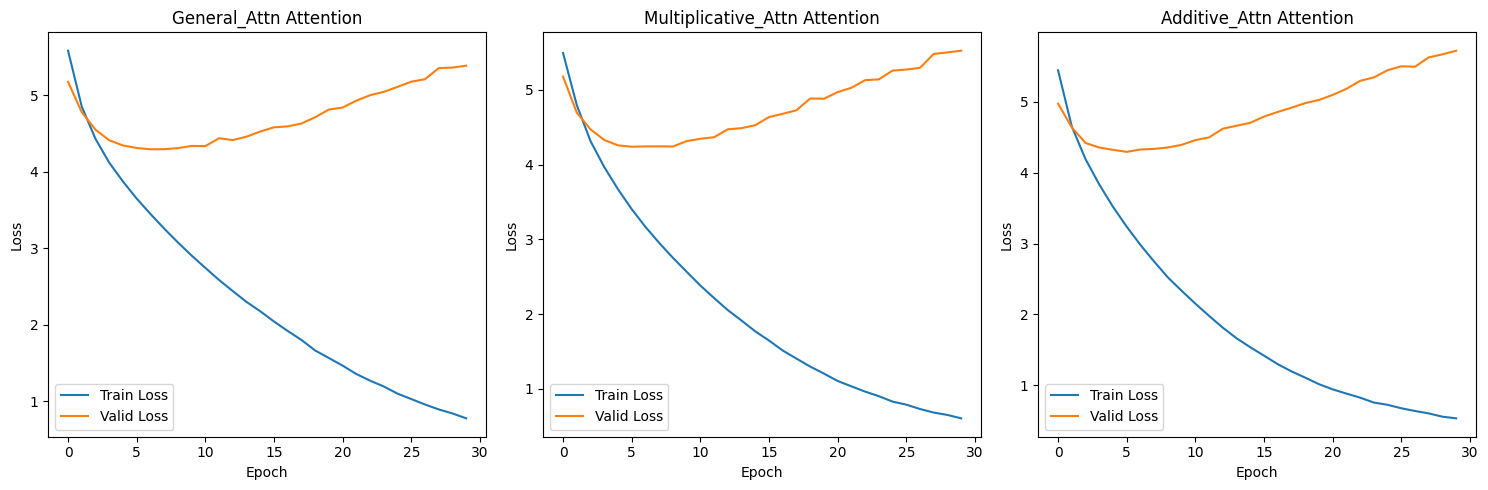

In [184]:
def plot_losses(train_losses, valid_losses, attn_type, ax):
    ax.plot(train_losses, label='Train Loss')
    ax.plot(valid_losses, label='Valid Loss')
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'{attn_type} Attention')

# Assuming results_by_attn_type has three attention types
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure with 3 subplots

# Ensure axs is a list for consistent indexing in case of single subplot
if len(results_by_attn_type) == 1:
    axs = [axs]

for i, (attn_type, data) in enumerate(results_by_attn_type.items()):
    plot_losses(data['train_losses'], data['valid_losses'], attn_type, axs[i])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [101]:
# Initialize list to store results
test_results = []

# Evaluate models and collect results
for attn_type, model in models.items():
    # Load saved parameters and state
    params, state = torch.load(f'./Models/{attn_type}_{model.__class__.__name__}.pt')
    
    # Initialize model with loaded parameters and state
    model = Seq2SeqTransformer(**params, device=device).to(device)
    model.load_state_dict(state)

    # Evaluate model on the test set
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    test_ppl = math.exp(test_loss)
    num_test_data = len(test_loader.dataset)  # Number of test data points

    # Append results to the list
    test_results.append([attn_type, num_test_data, f"{test_loss:.3f}", f"{test_ppl:.3f}"])

# Table headers
headers = ["Attention Type", "Number of Test Data", "Test Loss", "Test PPL"]

# Print table
print(tabulate(test_results, headers=headers, tablefmt="grid"))

+---------------------+-----------------------+-------------+------------+
| Attention Type      |   Number of Test Data |   Test Loss |   Test PPL |
+=====================+=======================+=============+============+
| General_Attn        |                   450 |       4.215 |     67.662 |
+---------------------+-----------------------+-------------+------------+
| Multiplicative_Attn |                   450 |       4.171 |     64.807 |
+---------------------+-----------------------+-------------+------------+
| Additive_Attn       |                   450 |       4.156 |     63.846 |
+---------------------+-----------------------+-------------+------------+


### Attention

Let's display the attentions to understand how the source text links with the generated text.
- **Function: `display_attention` Overview**:
    - **Purpose**: Generates and displays the attention plot for a given source and target sentence pair.
    - **Input**: Requires the source sentence (`sentence`), target translation (`translation`), and attention tensor (`attention`).
    - **Output**: Renders a matplotlib visualization of the attention weights between source and target tokens.
    - **Functionality**: Visualizes the alignment between source and target tokens by highlighting the attention weights.
    - **Example Usage**: Applied iteratively to display attention plots for multiple sentence pairs.

- **Function: `generate_attention_plot` Overview**:
    - **Purpose**: Orchestrates the process of generating attention plots for different attention types/models.
    - **Input**: Takes the trained model, source and target sentences, source and target languages, and device information as inputs.
    - **Output**: Produces attention plots for each attention type/model, visualizing the alignment between source and target tokens.
    - **Functionality**: Utilizes the trained model to generate translations and corresponding attention weights, which are then passed to the `display_attention` function for visualization.
    - **Example Usage**: Iterates over each model and generates attention plots for a sample sentence pair.

- **Attention Plot Generation**:
    - **Model Iteration**: Each trained model is loaded and initialized, allowing for the generation of attention plots specific to its attention mechanism.
    - **Model Loading**: Parameters and state are loaded from saved files for each model, ensuring consistency and reproducibility.
    - **Sample Sentence**: A sample sentence pair is chosen (e.g., from the test dataset) for attention plot generation.
    - **Attention Plot Generation**: The `generate_attention_plot` function is called to generate attention plots for each attention type/model.


In [185]:
def display_attention(sentence, translation, attention):
    # Specify the path to a font that supports Bangla characters
    bangla_font = FontProperties(fname='./font/SolaimanLipi_20-04-07.ttf')

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=12)  # Adjusted for better readability

    # Add an empty entry at the beginning for alignment
    y_ticks = [''] + translation
    x_ticks = [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45, fontproperties=bangla_font)
    ax.set_yticklabels(y_ticks, fontproperties=bangla_font)

    # Ensure each token is represented as a separate tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [188]:
def generate_attention_plot(model, src_sentence, trg_sentence, src_lang, trg_lang, device):
    src_text = text_transform[src_lang](src_sentence).to(device)
    trg_text = text_transform[trg_lang](trg_sentence).to(device)
    # print(src_text, trg_text)
    src_text = src_text.reshape(1, -1)  #because batch_size is 1
    trg_text = trg_text.reshape(1, -1)

    model.eval()
    with torch.no_grad():
        output, attentions = model(src_text, trg_text) #turn off teacher forcing

    text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1) #returns max indices
    mapping = vocab_transform[trg_lang].get_itos()

    attention = attentions[0, 0, :, :]

    src_tokens = ['<sos>'] + token_transform[src_lang](src_sentence) + ['<eos>']
    trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]

    display_attention(src_tokens, trg_tokens, attention)

/tmp/ipykernel_20446/3218959398.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45, fontproperties=bangla_font)
/tmp/ipykernel_20446/3218959398.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks, fontproperties=bangla_font)


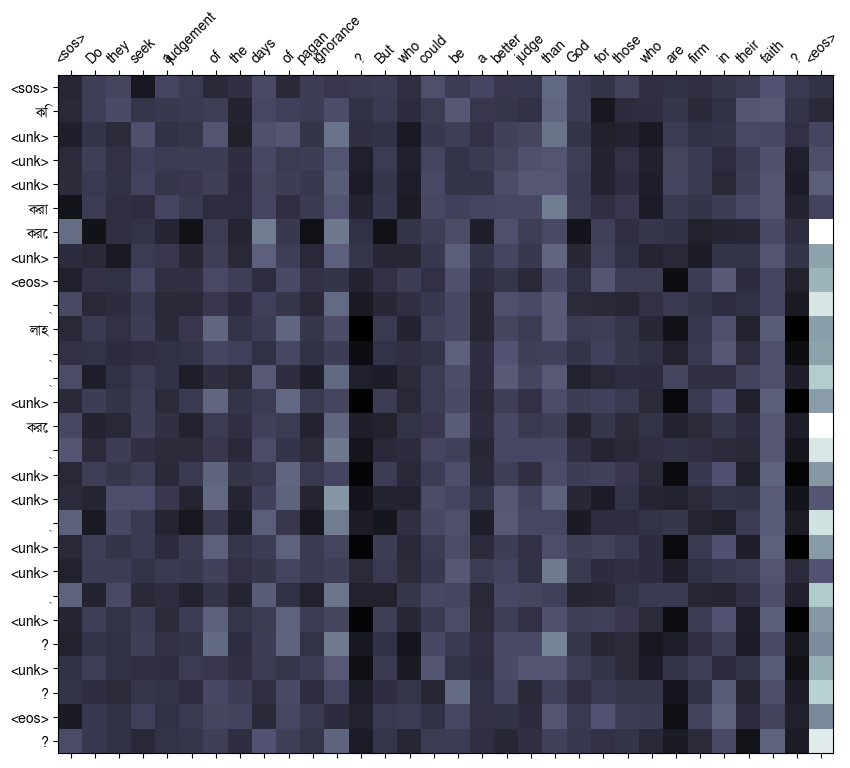

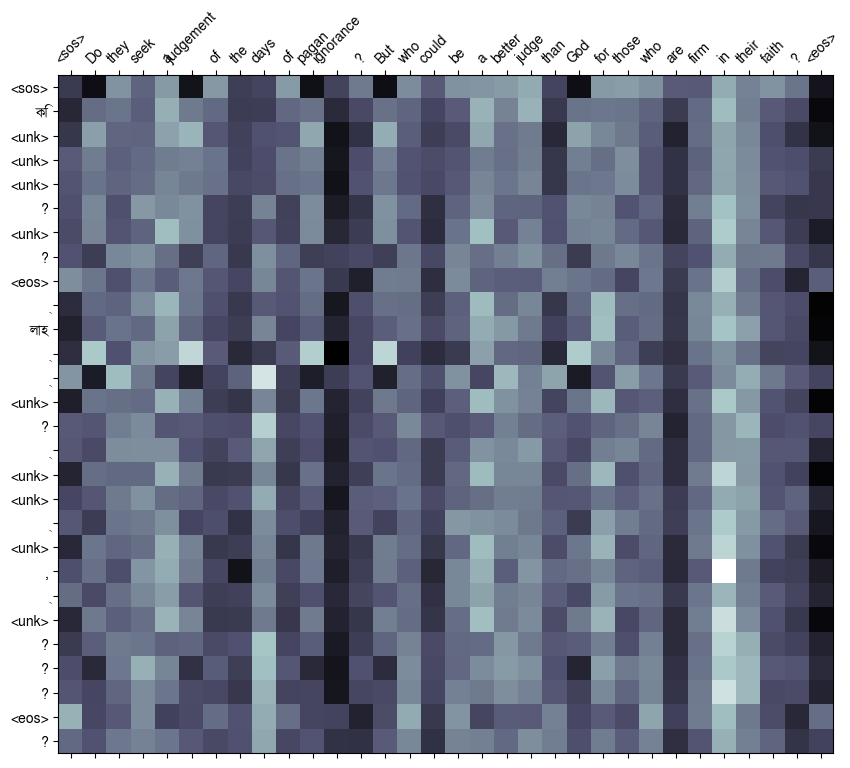

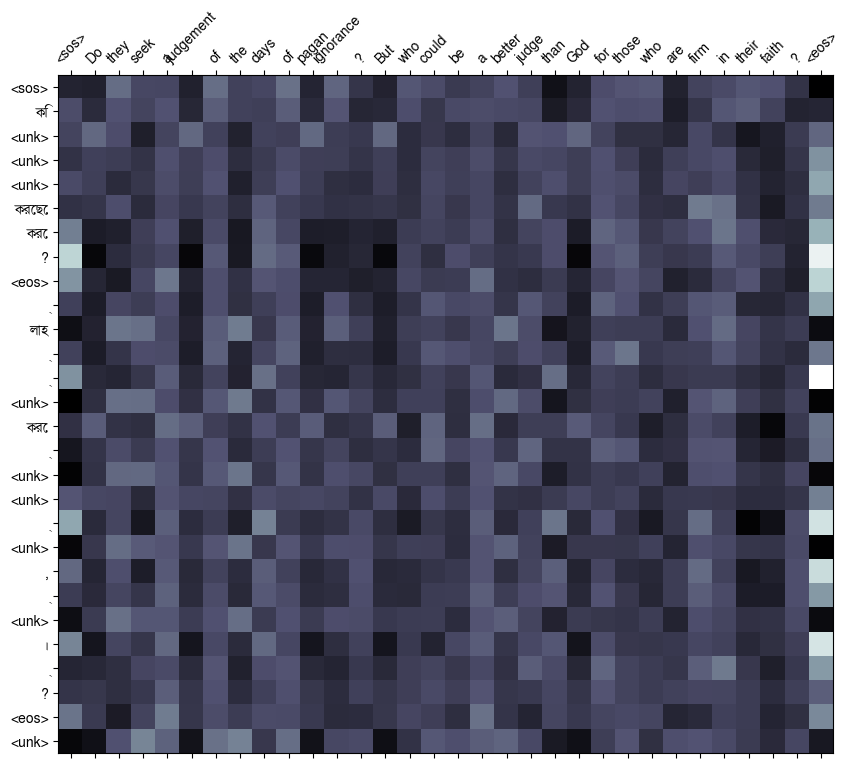

In [189]:
# Iterate over each model and generate attention plots
for attn_type, model in models.items():
    # Load saved parameters and state
    params, state = torch.load(f'./Models/{attn_type}_{model.__class__.__name__}.pt')
    
    # Initialize model with loaded parameters and state
    model = Seq2SeqTransformer(**params, device=device).to(device)
    model.load_state_dict(state)

    # Translate a sample sentence (you can change this sentence as needed)
    src_sentence = test_data[142]['en']
    trg_sentence = test_data[142]['bn']
    # print(src_sentence, trg_sentence)
    
    # Generate attention plot
    generate_attention_plot(model, src_sentence, trg_sentence, SRC_LANGUAGE, TRG_LANGUAGE, device)

## 8. Summary Report: English to Bangla Translation




#### Dataset Statistics

- **Dataset**: opus100 (bn-en)
- **Splits**: Train (2100 samples), Validation (450 samples), Test (450 samples)
- **Vocabulary Size**:
  - English (EN): 1625 words
  - Bangla (BN): 2023 words

#### Model Evaluation Criteria

The epoch with the lowest validation loss is selected for evaluation on the test dataset to ensure the best model performance is captured.

| Model Type            | Epoch with Lowest Validation Loss | Lowest Validation Loss |
|-----------------------|-----------------------------------|------------------------|
| General_Attn          | 7                                 | 4.29465                |
| Multiplicative_Attn   | 6                                 | 4.24075                |
| Additive_Attn         | 6                                 | 4.29108                |


#### Model Comparison

##### Translation Accuracy 

| Attention Type      | Avg. Train Loss | Avg. Train PPL | Avg. Valid Loss | Avg. Valid PPL | 
|---------------------|-----------------|----------------|-----------------|----------------|
| General_Attn        | 2.378           | 28.123         | **4.725**           | **120.592**        | 
| Multiplicative_Attn | 2.094           | 23.941         | 4.762           | 128.351        | 
| Additive_Attn       | **1.927**           | **21.132**         | 4.874           | 145.778        | 

##### Computational Efficiency

| Attention Type       | Avg. Epoch Time (seconds) |
|---------------------|---------------------------|
| General_Attn        | **106.333**                   |
| Multiplicative_Attn | 109.633                   |
| Additive_Attn       | 111.033                   |

##### Test Performance (Selected by Lowest Validation Loss)

| Attention Type      | Number of Test Data | Test Loss | Test PPL |
|---------------------|---------------------|-----------|----------|
| General_Attn        | 450                 | 4.215     | 67.662   |
| Multiplicative_Attn | 450                 | 4.171     | 64.807   |
| Additive_Attn       | 450                 | **4.156**     | **63.846**   |

#### Analysis and Discussion

- **Translation Accuracy**: Despite higher validation loss and PPL, Additive Attention demonstrates the best performance on the test set (also by considering the PPL and attention visualization), indicating its effectiveness in generalizing from the training data.

- **Computational Efficiency**: General Attention shows the best computational efficiency with the shortest average epoch time, making it suitable for environments with computational constraints.

- **Overall Effectiveness**: While General Attention offers a good balance between efficiency and accuracy, Additive Attention emerges as potentially more effective for practical applications due to its superior generalization on unseen data.


**Additive Attention** mechanism has been identified as the most effective for generalizing from training to unseen data in English to Bangla translation tasks. Despite a slightly higher computational cost, its superior performance on the test set makes it the preferred choice for applications where translation quality and accuracy are critical.


### Future Performance Improvement Strategies

Improving model performance requires a multifaceted approach, focusing on data preparation, model architecture adjustments, and training procedures. Here are some strategies that could help enhance the translation models' performance:

##### 1. Data Augmentation
- **Cleansing the Dataset**: Remove sentences other than source and target languages from the dataset to ensure cleaner training data.
- **Paraphrasing**: Generate paraphrased versions of the training sentences to enrich the dataset without altering the underlying meaning.
- **Back-Translation**: Increase the dataset size by translating target language sentences back into the source language and adding them as new training pairs.

##### 2. Hyperparameter Tuning
- **Learning Rate Adjustment**: Experiment with different learning rates or use learning rate schedulers to find the optimal rate for model training.
- **Batch Size Variation**: Test different batch sizes to find a balance between model performance, training speed, and memory usage.

##### 3. Advanced Model Architectures
- **Layer Normalization**: Incorporate layer normalization within the attention mechanisms to stabilize the learning process.
- **Transformer Modifications**: Explore variations of the Transformer architecture, such as the Transformer-XL, for improved handling of long-range dependencies.

##### 4. Expanding the Training Data
- **Entire Dataset Usage**: After cleansing, utilize the entire dataset for training by enhancing computational capabilities.
- **Diverse Sources**: Incorporate text from a wider range of sources to improve the model's ability to handle different styles and domains.
- **Cross-Lingual Transfer Learning**: Leverage transfer learning from models trained on high-resource language pairs to enhance performance on the target low-resource language pair.

##### 7. Evaluation and Iteration
- **Early Stopping**: Implement early stopping to prevent overfitting by halting the training when validation performance begins to deteriorate.
- **Continuous Evaluation**: Regularly evaluate the model on a validation set and adjust strategies based on performance trends.

## 9. Saving Model Vocabulary and Configuration




For reproducibility and ease of model deployment, it's essential to save not only the model's weights but also the vocabulary and configuration parameters used during training. This process involves:

1. **Saving Vocabulary**: The vocabulary mapping (from tokens to numerical indices) is crucial for both preprocessing new input data and interpreting model outputs.
2. **Storing Configuration Parameters**: Configuration parameters define the model architecture and training setup. Saving these details allows for the exact replication of the model structure and training environment.

#### Implementation Details:
- **Vocabulary Saving**: Utilizes PyTorch's `torch.save` function to serialize the vocabulary object.
- **Configuration Storage**: Configuration parameters are saved as a JSON file, providing a human-readable and easily accessible record of the model setup.

In [96]:
# save vocab
torch.save(vocab_transform,'./Models/vocab.pt')

# Configuration parameters
config = {
    "input_dim": input_dim,
    "output_dim": output_dim,
    "batch_size": batch_size,
    "lr": lr,
    "hid_dim": hid_dim,
    "enc_layers": enc_layers,
    "dec_layers": dec_layers,
    "enc_heads": enc_heads,
    "dec_heads": dec_heads,
    "enc_pf_dim": enc_pf_dim,
    "dec_pf_dim": dec_pf_dim,
    "enc_dropout": enc_dropout,
    "dec_dropout": dec_dropout,
    "SRC_PAD_IDX": PAD_IDX ,  # Assuming PAD_IDX is a placeholder; replace it with the actual value
    "TRG_PAD_IDX": PAD_IDX   # Assuming PAD_IDX is a placeholder; replace it with the actual value
}

# Save configuration to a JSON file
config_file_path = './Models/model_config.json'
with open(config_file_path, 'w') as config_file:
    json.dump(config, config_file, indent=4)

print(f"Configuration saved to {config_file_path}.")


Configuration saved to ./Models/model_config.json.


## 10. Inference

- **Data Loading and Configuration Setup**:
    - **Vocabulary Loading**: Loads vocabulary information from a saved file (`vocab.pt`) using `torch.load`.
    - **Model Configuration File**: Reads model configuration values from a JSON file (`model_config.json`), containing parameters such as input and output dimensions, batch size, learning rate, hidden dimensions, layer configurations, attention heads, etc.
    - **Configuration Assignment**: Assigns loaded configuration values to respective variables for further usage in model initialization and training setup.
    - **Variable Usage**: These variables can now be utilized to configure and initialize the model, define training hyperparameters, set up optimizers, loss functions, etc.
    - **Print Confirmation**: Prints a message confirming the successful loading and assignment of model configuration values for verification and debugging purposes.


In [37]:
vocab_transform = torch.load('./Models/vocab.pt')

In [38]:
# Load configuration from a JSON file
config_file_path = './Models/model_config.json'
with open(config_file_path, 'r') as config_file:
    loaded_config = json.load(config_file)

# Assign the loaded configuration values to variables
input_dim = loaded_config["input_dim"]
output_dim = loaded_config["output_dim"]
batch_size = loaded_config["batch_size"]
lr = loaded_config["lr"]
hid_dim = loaded_config["hid_dim"]
enc_layers = loaded_config["enc_layers"]
dec_layers = loaded_config["dec_layers"]
enc_heads = loaded_config["enc_heads"]
dec_heads = loaded_config["dec_heads"]
enc_pf_dim = loaded_config["enc_pf_dim"]
dec_pf_dim = loaded_config["dec_pf_dim"]
enc_dropout = loaded_config["enc_dropout"]
dec_dropout = loaded_config["dec_dropout"]
SRC_PAD_IDX = loaded_config["SRC_PAD_IDX"]
TRG_PAD_IDX = loaded_config["TRG_PAD_IDX"]

# Now,use these variables to initialize your model, set up your training configuration, etc.
print(f"Model Configuration Loaded: Input Dim: {input_dim}, Output Dim: {output_dim}, etc.")

Model Configuration Loaded: Input Dim: 1625, Output Dim: 2023, etc.


**Loading Models**

In [45]:
# Define Encoder, Decoder, Seq2SeqTransformer, and initialize_weights functions if not defined already

# List of attention types
attn_type_li = ['General_Attn', 'Multiplicative_Attn', 'Additive_Attn']

# Dictionary to store initialized models
models = {}

# Loop over each attention type
for attn_type in attn_type_li:
    print(f"\n****************{attn_type}****************\n")
    # Initialize encoder
    enc = Encoder(input_dim,
                  hid_dim,
                  enc_layers,
                  enc_heads,
                  enc_pf_dim,
                  enc_dropout,
                  device,
                  attn_type
                  )

    # Initialize decoder
    dec = Decoder(output_dim,
                  hid_dim,
                  dec_layers,
                  dec_heads,
                  dec_pf_dim,
                  enc_dropout,
                  device,
                  attn_type)

    # Create Seq2SeqTransformer model with specified attention type
    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    
    # Apply weight initialization
    model.apply(initialize_weights)
    
    # Store initialized model in the dictionary with attention type as key
    models[attn_type] = model

    # Print number of parameters for the current model
    print(models[attn_type])



****************General_Attn****************

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(1625, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): AttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (W): Linear(in_features=32, out_features=32, bias=True)
          (W1): Linear(in_features=32, out_features=32, bias=True)
          (W2): Linear(in_features=32, out_features=32, bias=True)
          (v): Linear(in_feat

In [46]:
# Dictionary to store loaded models
loaded_models = {}

# Loop over each attention type
for attn_type, model_path in models.items():
    print(f"\nLoading model for {attn_type}")
    # Load model parameters and state
    params, state = torch.load(f"./Models/{attn_type}_Seq2SeqTransformer.pt", map_location=device)
    
    # Create a new Seq2SeqTransformer model with loaded parameters
    model = Seq2SeqTransformer(**params, device=device)
    
    # Load the state dictionary
    model.load_state_dict(state)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Store the loaded model in the dictionary with attention type as key
    loaded_models[attn_type] = model

    print(f"Model for {attn_type} loaded successfully.")

# Now 'loaded_models' contains all our models loaded from the saved files


Loading model for General_Attn
Model for General_Attn loaded successfully.

Loading model for Multiplicative_Attn
Model for Multiplicative_Attn loaded successfully.

Loading model for Additive_Attn
Model for Additive_Attn loaded successfully.


- **Translation Function: `translate_sentence`**:
    - **Purpose**: Translates a given input sentence into the target language using a trained sequence-to-sequence Transformer model.
    - **Input**:
        - `sentence`: The input sentence to be translated.
        - `src_vocab_transform`: Vocabulary transformation for the source language.
        - `trg_vocab_transform`: Vocabulary transformation for the target language.
        - `model`: The trained Transformer model for translation.
        - `device`: The device (CPU or GPU) where the model is loaded.
        - `max_len`: Maximum length of the output sentence (default is 50).
    - **Output**: The translated sentence in the target language.
    - **Functionality**:
        - Tokenizes and numericalizes the input sentence using the source language vocabulary.
        - Generates the translation by iteratively predicting each token in the target language, incorporating attention mechanisms.
        - Stops the translation when the end-of-sequence token is encountered or when the maximum length is reached.
        - Converts predicted indices back to tokens using the target language vocabulary.
        - Joins the tokens to form the translated sentence, excluding the start-of-sequence token.


In [53]:
# Define the translate_sentence function with model as parameter
def translate_sentence(sentence, src_vocab_transform, trg_vocab_transform, model, device, max_len=50):
    model.eval()
    
    # Tokenize and numericalize the input sentence
    tokens = [token.lower() for token in token_transform[SRC_LANGUAGE](sentence)]
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab_transform[token] for token in tokens]
    
    # Convert to tensor and add batch dimension
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    # Create source mask
    src_mask = model.make_src_mask(src_tensor)
    
    # Generate output (forward pass)
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
        trg_indexes = [trg_vocab_transform['<sos>']]
        
        for i in range(max_len):
            trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            trg_mask = model.make_trg_mask(trg_tensor)
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
            pred_token = output.argmax(2)[:, -1].item()
            trg_indexes.append(pred_token)
            
            if pred_token == trg_vocab_transform['<eos>']:
                break
    
    # Convert indices to tokens
    trg_tokens = [trg_vocab_transform.get_itos()[i] for i in trg_indexes]
    
    # Join tokens to form the output sentence (skip <sos> token)
    return ' '.join(trg_tokens[1:])

# Iterate over random samples and translate using all loaded models
random_samples = random.sample(list(enumerate(test_data)), 5)
for index, sample in random_samples:
    src_sentence = sample['en']
    print(f"Index: {index}, Original text: {src_sentence}")
    
    # Translate sentence for each model and print results
    for attn_type, model in loaded_models.items():
        # Translate sentence using the current model
        translation = translate_sentence(src_sentence, vocab_transform[SRC_LANGUAGE], vocab_transform[TRG_LANGUAGE], model, device)
        
        # Print the attention type and translation
        print(f"Attention Type: {attn_type}, Translation: {translation}")
    
    # Print a separator for readability between samples
    print("-" * 50)


Index: 295, Original text: #ToDoListForBuhari - Get rid of Sharia Law.
Attention Type: General_Attn, Translation: <unk> <unk> <unk> <unk> <unk> <unk> - <unk> <unk> <unk> . <eos>
Attention Type: Multiplicative_Attn, Translation: <unk> <unk> <unk> <unk> । <eos>
Attention Type: Additive_Attn, Translation: - <unk> <unk> <unk> <unk> <unk> <eos>
--------------------------------------------------
Index: 322, Original text: We , will call the Zabania ( the harsh angels of Hell ) .
Attention Type: General_Attn, Translation: আমরা <unk> <unk> <unk> <unk> , <unk> <unk> । <eos>
Attention Type: Multiplicative_Attn, Translation: <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> । <eos>
Attention Type: Additive_Attn, Translation: আর আমরা <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> । <eos>
--------------------------------------------------
Index: 351, Original text: Let me risk a little more light.
Attention Type: General_Attn, Translation: এই <unk> . <eos>
Attention Type: Multiplic